In [2]:
from models import *
from datetime import datetime, timedelta
import math


In [3]:
# INSTANTIATE MODELS
collector = SolarCollector(180)
storage_tank = Storage(200)
# BASED ON 4500 kg (Liters water/day) over 8hrs (Load_profile) m_l_dot = 0.15
water = Load(60, load_mass_flow_rate=0.156)

In [4]:
# Load Profile
import json
with open('./load_profile.json') as f:
    water_usage = json.load(f)
water_consumption = water_usage["load_profile"]
water_consumption

FileNotFoundError: [Errno 2] No such file or directory: './load_profile.json'

In [ ]:
collector.weather_conditions

,poa_global,solar_elevation,temp_air,wind_speed,Int
time,,,,,
2006-01-01 05:00:00+05:30,0.00,0.00,13.82,4.03,0
2006-01-01 06:00:00+05:30,0.00,0.00,14.85,3.88,0
2006-01-01 07:00:00+05:30,0.00,1.33,15.88,3.72,1
2006-01-01 08:00:00+05:30,254.01,13.93,16.91,3.57,0
2006-01-01 09:00:00+05:30,532.72,25.69,19.91,3.94,0
...,...,...,...,...,...
2007-01-01 00:00:00+05:30,0.00,0.00,19.29,2.57,0
2007-01-01 01:00:00+05:30,0.00,0.00,18.58,2.50,0
2007-01-01 02:00:00+05:30,0.00,0.00,17.86,2.43,0


In [ ]:
# Simulation Params
YEAR = 2006
MONTH = 1
DAY_START = 1
DAY_END = 31
SIMULATION_TIME_STEP=300

In [ ]:
environment_conditions = collector.weather_conditions
# environment_conditions = environment_conditions[(environment_conditions.index.year==YEAR) & (environment_conditions.index.month == MONTH) & ((environment_conditions.index.day >= DAY_START) & (environment_conditions.index.day < DAY_END))]

In [ ]:
environment_conditions

,poa_global,solar_elevation,temp_air,wind_speed,Int
time,,,,,
2006-01-01 05:00:00+05:30,0.00,0.00,13.82,4.03,0
2006-01-01 06:00:00+05:30,0.00,0.00,14.85,3.88,0
2006-01-01 07:00:00+05:30,0.00,1.33,15.88,3.72,1
2006-01-01 08:00:00+05:30,254.01,13.93,16.91,3.57,0
2006-01-01 09:00:00+05:30,532.72,25.69,19.91,3.94,0
...,...,...,...,...,...
2007-01-01 00:00:00+05:30,0.00,0.00,19.29,2.57,0
2007-01-01 01:00:00+05:30,0.00,0.00,18.58,2.50,0
2007-01-01 02:00:00+05:30,0.00,0.00,17.86,2.43,0


In [ ]:
# GET I_t & water consumption at timestep

def is_water_consumed(current_time, water_consumption):
    is_water_consumed = False
    
    for period in water_consumption:
        # Convert start and end times to datetime.time for comparison
        start_time = datetime.strptime(period["start"], "%H:%M").time()
        end_time = datetime.strptime(period["end"], "%H:%M").time()
        
        # Check if current_time falls within the consumption period
        if start_time <= current_time < end_time:
            # print("REACHED")
            is_water_consumed = True
            break  # Exit the loop if a matching period is found
    return is_water_consumed

def get_solar_radiation_and_temperature(current_date_time, environment_conditions):
    
    print(current_date_time)

    # Determine the hour in which current_date_time lies, This floors the time to the start of the current hour
    hour_start = current_date_time.replace(minute=0, second=0, microsecond=0)
    # print(hour_start)
    # Since we are using hourly data, ensure to check if the hour_start exceeds the dataframe's range
    # If it does, use the last available hour in the dataframe
    if hour_start not in environment_conditions.index:
        hour_start = environment_conditions.index[-1]

    # Now, use hour_start to index the DataFrame and get poa_global and temp_air
    poa_global = environment_conditions.loc[hour_start, 'poa_global']
    temp_air = environment_conditions.loc[hour_start, 'temp_air']

    return poa_global, temp_air

In [ ]:
A_c = collector.A_c
F_r_tao_aplha = collector.F_r_tao_aplha
F_r_U_l = collector.F_r_U_l
m_l_dot = water.m_l
C_p = storage_tank.C_p
T_l = water.T_l
U_st = storage_tank.U_st
A_st = storage_tank.A_st
rho = storage_tank.rho
V_st = storage_tank.V_st

print(f"A_c:{A_c}")
print(f"F_r_tao_aplha:{F_r_tao_aplha}")
print(f"F_r_U_l:{F_r_U_l}")
print(f"m_l_dot:{m_l_dot}")
print(f"C_p:{C_p}")
print(f"T_l:{T_l}")
print(f"U_st:{U_st}")
print(f"V_st:{V_st}")
print(f"A_st:{A_st}")

def get_solar_useful_gain_rate(I_t, T_st, T_a):
    if int(I_t) == 0:
        return 0.0
    return A_c * (I_t * F_r_tao_aplha - F_r_U_l * (T_st - T_a))
    

def handle_case_1(I_t, T_sti, T_a, delta_t):
    """
        Solving equation 11a analytically
    """
    k_1 = A_c * F_r_U_l + U_st * A_st
    k_2 = A_c * I_t * F_r_tao_aplha + A_c * F_r_U_l * T_a - m_l_dot * C_p * (T_l - T_a) + U_st * A_st * T_a
    k_3 = ((U_st * A_st + A_c * F_r_U_l) / (rho * C_p * V_st))
    T_stf = (k_2 - (k_2 - k_1 * T_sti) * math.exp(-k_3 * delta_t)) / k_1
    return T_stf


def handle_case_2(I_t, T_sti, T_a, delta_t):
    """
        Solving equation 11b analytically
    """
    # c1
    heat_supplied_load = m_l_dot * C_p * (T_l - T_a)
    # Storage coeff c2
    storage_loss_coeff = U_st * A_st
    # c_3
    c_3 = ((U_st * A_st) / (rho * C_p * V_st))
    T_stf = (storage_loss_coeff * T_a - heat_supplied_load 
             - math.exp(-c_3 * delta_t) * (storage_loss_coeff * T_a - heat_supplied_load - storage_loss_coeff * T_sti)) / (storage_loss_coeff)
    return T_stf


def handle_case_3(I_t, T_sti, T_a, delta_t):
    """
        Solving equation 11c analytically
    """
    # k1
    k_1 = A_c * I_t * F_r_tao_aplha + T_a * (A_c * F_r_U_l + m_l_dot * C_p + U_st * A_st)
    # k_2
    k_2 = A_c * F_r_U_l + m_l_dot * C_p + U_st * A_st
    #k_3
    k_3 = (A_c * F_r_U_l + U_st * A_st + m_l_dot * C_p) / (rho * C_p * V_st)

    T_stf = (k_1 - math.exp(- k_3 * delta_t) * (k_1 - k_2 * T_sti)) / k_2
    return T_stf

def handle_case_4(I_t, T_sti, T_a, delta_t):
    """
        Solving equation 11d analytically
    """
    c_1 = m_l_dot * C_p
    c_2 = U_st * A_st
    c_3 = (c_1 + c_2) / (rho * C_p * V_st)

    T_stf = (T_a * (c_1 + c_2) - math.exp(-(c_3 * delta_t)) * (T_a * (c_1 + c_2) - T_sti * (c_1 + c_2))) / (c_1 + c_2)
    return T_stf

def get_next_temperature(I_t, T_sti, T_a, delta_t):
    """
        Solve the differential equations from the energy balance of the tank
    """
    q_s = get_solar_useful_gain_rate(I_t, T_sti, T_a)
    # q_s = q_s if q_s > 0 else 0.0

    # Case 1
    if T_sti > T_l and q_s > 0:
        return handle_case_1(I_t, T_sti, T_a, delta_t)
    elif T_sti > T_l and q_s <= 0:
        return handle_case_2(I_t, T_sti, T_a, delta_t)
    elif T_sti <= T_l and q_s > 0:
        return handle_case_3(I_t, T_sti, T_a, delta_t)
    else:
        return handle_case_4(I_t, T_sti, T_a, delta_t)


A_c:180
F_r_tao_aplha:0.675
F_r_U_l:5.656
m_l_dot:0.156
C_p:4180
T_l:60
U_st:0.199
V_st:200
A_st:189.2943372971103


In [ ]:
# SIMULATION LOOP

# Define the simulation start time
simulation_start = datetime(YEAR, MONTH, DAY_START)

# Define the number of seconds in a day and the simulation time step in seconds
seconds_in_a_day = 24 * 60 * 60
time_step = 300

temperature_profile = [69]

# # Initialize a list to hold the poa_global and temp_air values for each time step
# simulation_data = []
# TODO: THIS IS IMPORTANT
environment_conditions.index = environment_conditions.index.tz_localize(None)
# Loop through each time step in the simulation period
for timestep in range(0, 30 * seconds_in_a_day, time_step):
    # Calculate the current simulation time
    current_date_time = simulation_start + timedelta(seconds=timestep)
    

    I_t, T_a = get_solar_radiation_and_temperature(current_date_time, environment_conditions)
    # print(I_t, T_a)

    current_time = current_date_time.time()
    is_consumed = is_water_consumed(current_time, water_consumption)
    # print(is_water_consumed(current_time, water_consumption))
    print("CRRTIME", current_time)
    if not is_consumed:
        temperature_profile.append(temperature_profile[-1])
    else:
        delta_t = time_step
        temperature_profile.append(get_next_temperature(I_t, temperature_profile[-1], T_a, time_step))




2006-01-01 00:00:00
CRRTIME 00:00:00
2006-01-01 00:05:00
CRRTIME 00:05:00
2006-01-01 00:10:00
CRRTIME 00:10:00
2006-01-01 00:15:00
CRRTIME 00:15:00
2006-01-01 00:20:00
CRRTIME 00:20:00
2006-01-01 00:25:00
CRRTIME 00:25:00
2006-01-01 00:30:00
CRRTIME 00:30:00
2006-01-01 00:35:00
CRRTIME 00:35:00
2006-01-01 00:40:00
CRRTIME 00:40:00
2006-01-01 00:45:00
CRRTIME 00:45:00
2006-01-01 00:50:00
CRRTIME 00:50:00
2006-01-01 00:55:00
CRRTIME 00:55:00
2006-01-01 01:00:00
CRRTIME 01:00:00
2006-01-01 01:05:00
CRRTIME 01:05:00
2006-01-01 01:10:00
CRRTIME 01:10:00
2006-01-01 01:15:00
CRRTIME 01:15:00
2006-01-01 01:20:00
CRRTIME 01:20:00
2006-01-01 01:25:00
CRRTIME 01:25:00
2006-01-01 01:30:00
CRRTIME 01:30:00
2006-01-01 01:35:00
CRRTIME 01:35:00
2006-01-01 01:40:00
CRRTIME 01:40:00
2006-01-01 01:45:00
CRRTIME 01:45:00
2006-01-01 01:50:00
CRRTIME 01:50:00
2006-01-01 01:55:00
CRRTIME 01:55:00
2006-01-01 02:00:00
CRRTIME 02:00:00
2006-01-01 02:05:00
CRRTIME 02:05:00
2006-01-01 02:10:00
CRRTIME 02:10:00
2

In [ ]:
# print(temperature_profile)
print(len(temperature_profile))

8641


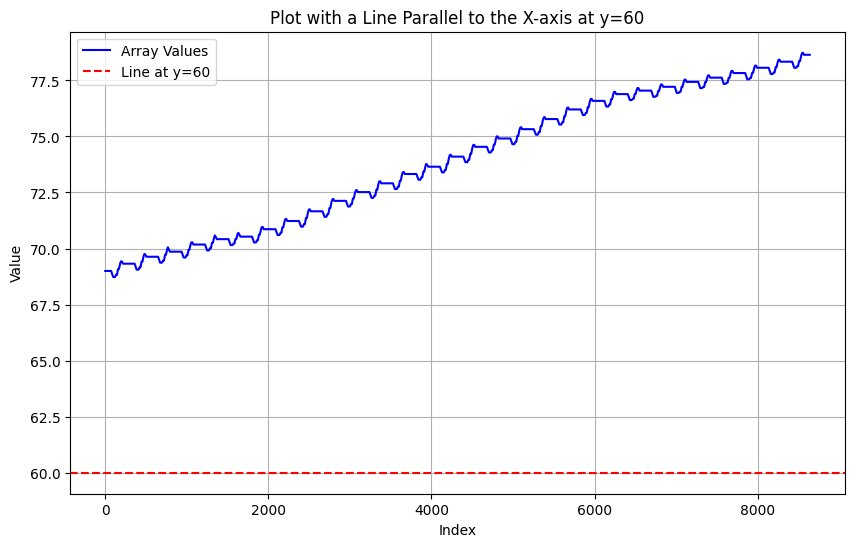

In [ ]:
# Re-importing necessary libraries and re-plotting after reset
import numpy as np
import matplotlib.pyplot as plt


# Plotting the array
plt.figure(figsize=(10, 6))
plt.plot(temperature_profile, color='blue', label='Array Values')

# Plotting a line parallel to the x-axis at y=60
plt.axhline(y=60, color='red', linestyle='--', label='Line at y=60')

# plt.ylim(20, 150)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot with a Line Parallel to the X-axis at y=60')
plt.legend()
plt.grid(True)
plt.show()
